In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
import torch
import os
from pathlib import Path
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import numpy as np


DATASET = os.getenv("DATASET")
imagenet_dir = Path(DATASET) / "imagenet" / "ilsvrc2012"
# model = torch.hub.load("facebookresearch/dino:main", "dino_vits16")
torch.no_grad()


In [42]:
import vision_transformer as vits
import utils
from vision_transformer import DINOHead
from main_dino import DINOLoss

model = vits.__dict__["vit_small"](patch_size=16)
utils.load_pretrained_weights(
    model,
    "/mnt/raid/hli/models/dino/train_drop/checkpoint.pth",
    "teacher",
    "vit_small",
    16,
)

teacher = utils.MultiCropWrapper(
    model,
    DINOHead(model.embed_dim, 65536, False),
)

dino_loss = DINOLoss(
    65536,
    8 + 2,  # total number of crops = 2 global crops + local_crops_number
    0.04,
    0.04,
    0,
    1200,
)

# utils.restart_from_checkpoint(
#         os.path.join("/mnt/raid/hli/models/dino/train_no_head", "checkpoint.pth"),
#         teacher=teacher,
#         dino_loss=dino_loss,
#     )

# utils.load_pretrained_weights(
#         model, "", None, "vit_small", 16
#     )
# train_subset
# train_no_shed
# train_drop
# train_drop_no_shed
# train_no_head
# train_drop_no_aug


Take key teacher in provided checkpoint dict
Pretrained weights found at /mnt/raid/hli/models/dino/train_drop/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [43]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
dataset = ImageFolder(imagenet_dir / "train", transform)


In [44]:
image = transforms.functional.rotate(dataset[18200][0], 0)
input_image = image.unsqueeze(0)

output = model(input_image, debug=True)


In [45]:
import numpy as np

np.random.seed(0)
ids = np.random.permutation(len(dataset))[:1201]
18200 in ids


False

In [46]:
@torch.no_grad()
def get_color(x, clip_index=1):
    x = torch.clone(x)
    x = x[0, clip_index:].view(14, 14, -1)
    # color = output_patch.norm(dim=2,keepdim=True)
    return x[:, :, 30:33]


@torch.no_grad()
def norm_color(x):
    x = torch.clone(x)
    x -= x.min()
    x /= x.max()
    return x


@torch.no_grad()
def visualize_patch_embeddings(rot=0, state=0):
    image = transforms.functional.rotate(dataset[18200][0], rot)
    input_image = image.unsqueeze(0)

    output, patch_emb, pos_emb, hidden_states = model(input_image, debug=True)

    color = norm_color(get_color(output))
    color_patch = get_color(patch_emb, 0)
    color_pos = get_color(pos_emb)
    color_plus = color_patch + color_pos
    color_patch = norm_color(color_patch)
    color_pos = norm_color(color_pos)
    color_plus = norm_color(color_plus)
    hidden_color = [norm_color(get_color(x)) for x in hidden_states]
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    axes.flatten()[0].imshow(rearrange(input_image[0], "c h w -> h w c"))
    axes.flatten()[1].imshow(
        repeat(color, "h w c -> (h k) (w p) (c l)", k=16, p=16, l=1).detach()
    )
    axes.flatten()[3].imshow(
        repeat(color_patch, "h w c -> (h k) (w p) (c l)", k=16, p=16, l=1).detach()
    )
    axes.flatten()[4].imshow(
        repeat(color_pos, "h w c -> (h k) (w p) (c l)", k=16, p=16, l=1).detach()
    )
    axes.flatten()[5].imshow(
        repeat(color_plus, "h w c -> (h k) (w p) (c l)", k=16, p=16, l=1).detach()
    )
    axes.flatten()[2].imshow(
        repeat(
            hidden_color[state], "h w c -> (h k) (w p) (c l)", k=16, p=16, l=1
        ).detach()
    )


In [47]:
interact(
    visualize_patch_embeddings,
    rot=widgets.IntSlider(min=-180, max=180, step=30, value=0),
    state=widgets.IntSlider(min=0, max=11, step=1, value=5),
)


interactive(children=(IntSlider(value=0, description='rot', max=180, min=-180, step=30), IntSlider(value=5, de…

<function __main__.visualize_patch_embeddings(rot=0, state=0)>

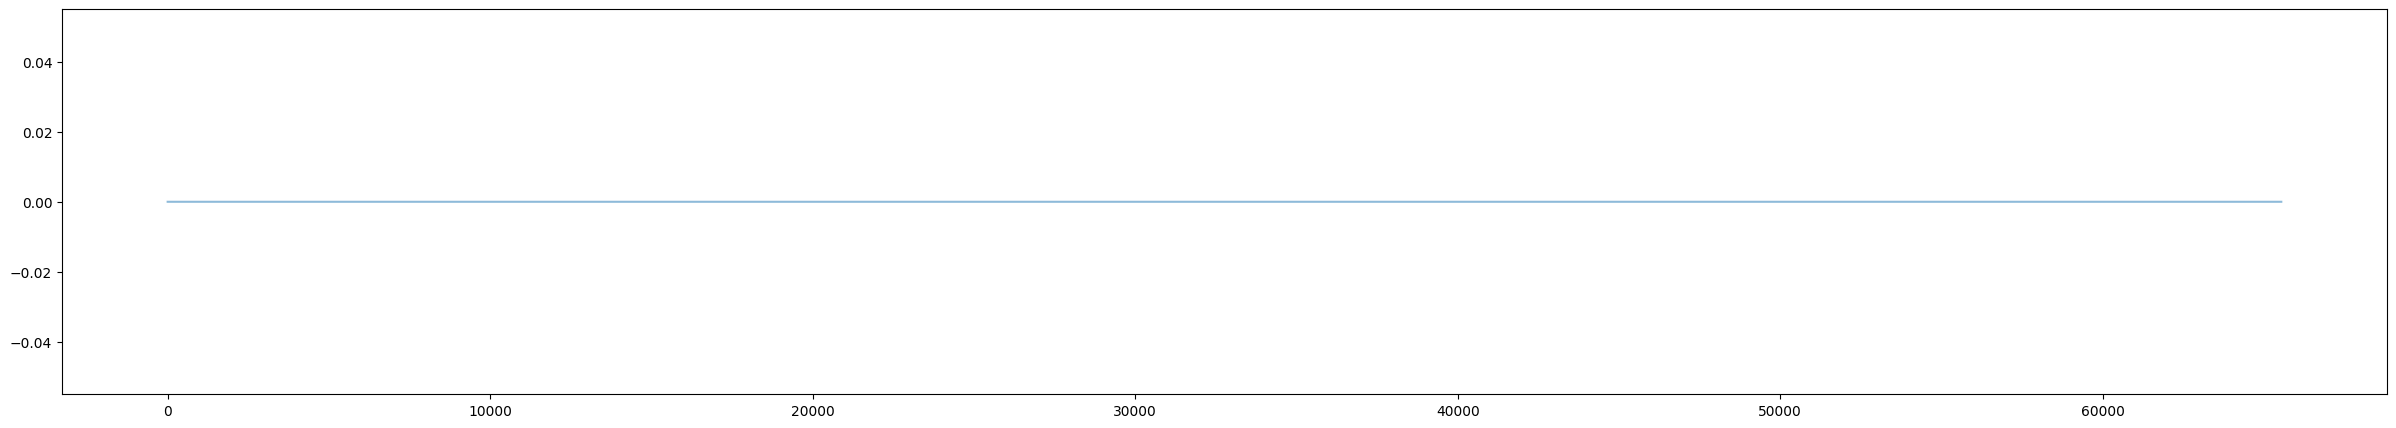

In [48]:
x_size = 65536
y = np.arange(x_size)
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(y, dino_loss.center[0, :x_size].cpu(), alpha=0.5)


In [49]:
image = transforms.functional.rotate(dataset[18200][0], 0)
image2 = transforms.functional.rotate(dataset[1555][0], 0)
image3 = transforms.functional.rotate(dataset[18200][0], 15)
input_image = torch.stack((image, image2, image3))


In [50]:
import torch.nn.functional as F

output, patch_emb, pos_emb, hidden_states = model(input_image, debug=True)
# output = F.softmax((output - dino_loss.center) / 0.04, dim=-1)


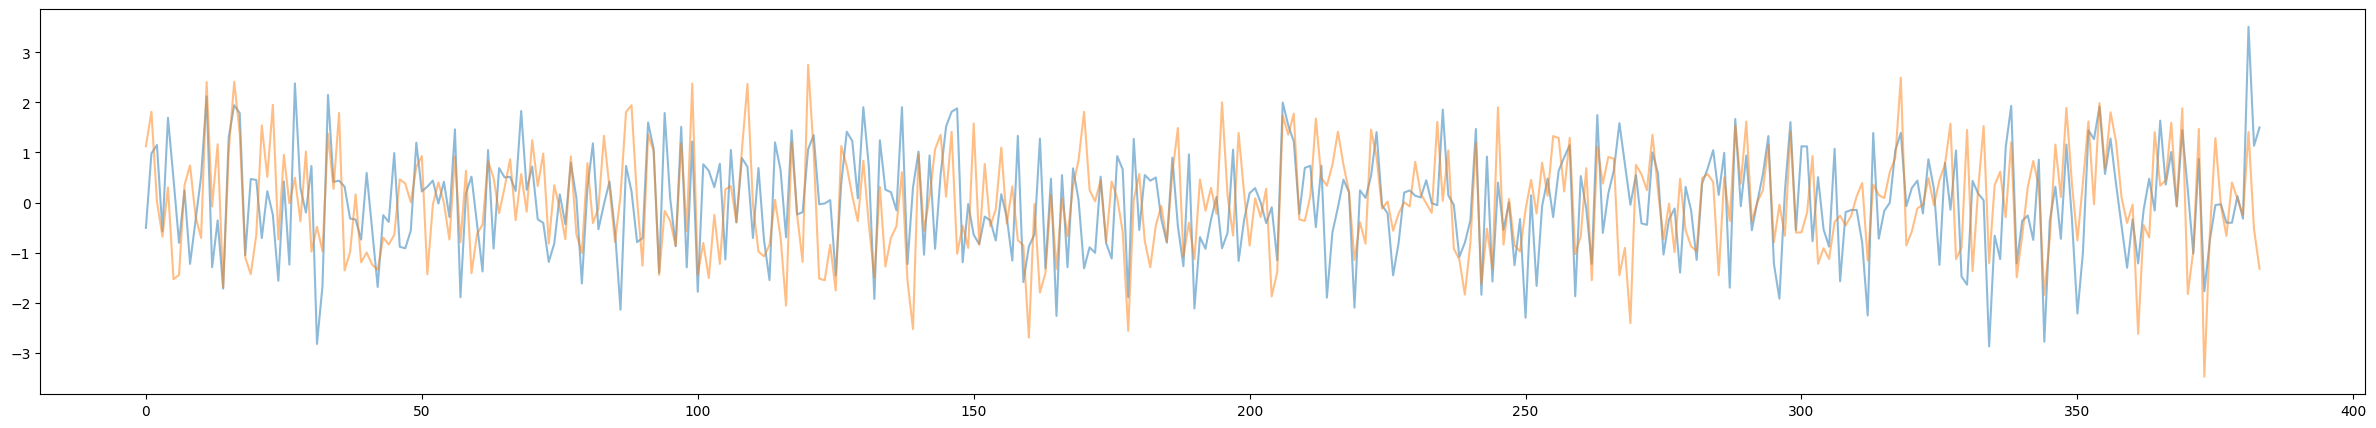

In [51]:
y = np.arange(output.size(-1))
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(y, output[0, 0].detach().cpu(), alpha=0.5)
ax.plot(y, output[1, 0].detach().cpu(), alpha=0.5)


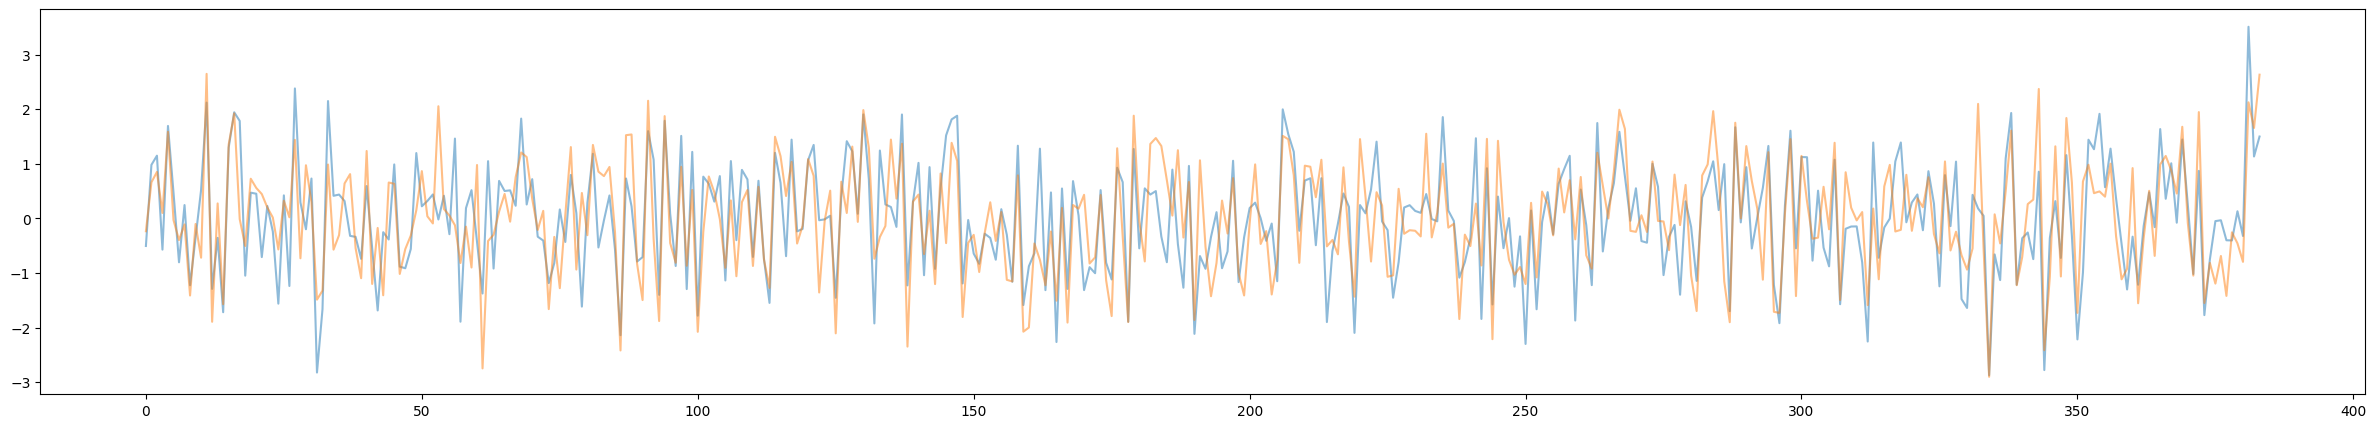

In [52]:
y = np.arange(output.size(-1))
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(y, output[0, 0].detach().cpu(), alpha=0.5)
ax.plot(y, output[2, 0].detach().cpu(), alpha=0.5)


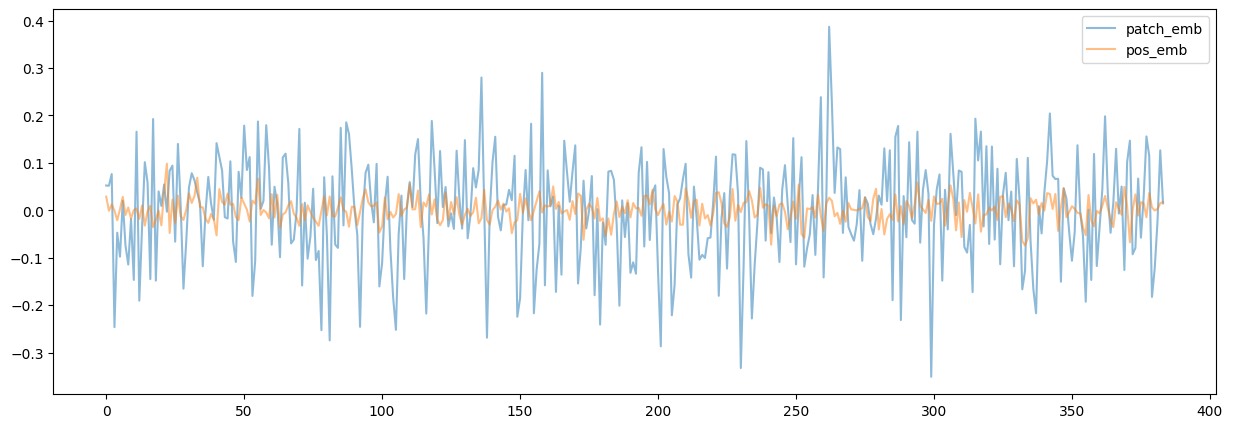

In [53]:
y = np.arange(output.size(-1))
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y, patch_emb[0, -10].detach().cpu(), alpha=0.5, label="patch_emb")
ax.plot(y, pos_emb[0, -10].detach().cpu(), alpha=0.5, label="pos_emb")
ax.legend()


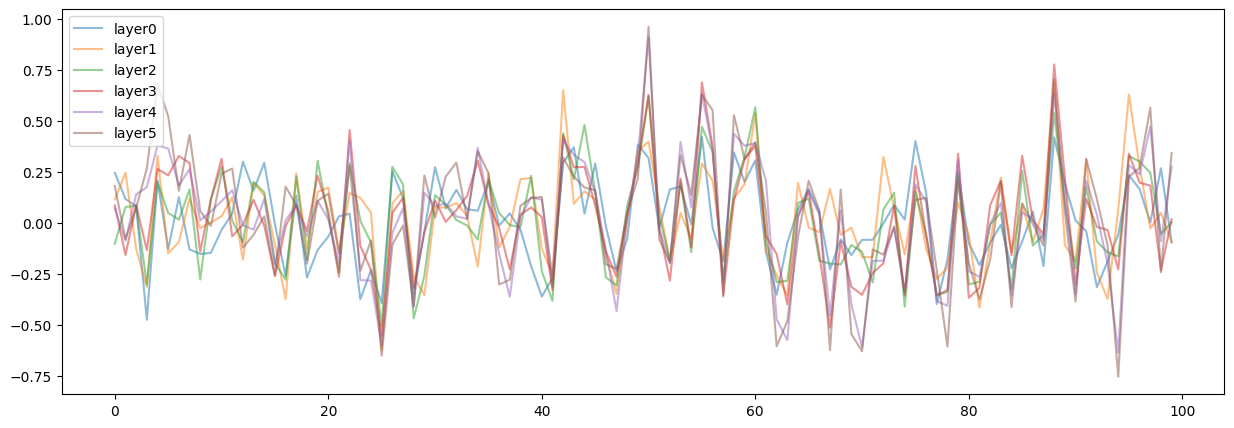

In [54]:
plot_dim = 100
plot_patch_num = -10

y = np.arange(100)
fig, ax = plt.subplots(figsize=(15, 5))

# ax.plot(y, patch_emb[0,plot_patch_num][:plot_dim].detach().cpu()+pos_emb[0,plot_patch_num][:plot_dim].detach().cpu(), alpha=0.5, label="sum")

labels = [
    "layer0",
    "layer1",
    "layer2",
    "layer3",
    "layer4",
    "layer5",
    "layer6",
    "layer7",
    "layer8",
    "layer9",
    "layer10",
    "layer11",
]
for i, s in enumerate(hidden_states):
    if i >= 6:
        continue
    ax.plot(
        y,
        s[0][plot_patch_num][:plot_dim].detach().cpu().numpy(),
        alpha=0.5,
        label=labels[i],
    )

ax.legend()
